In [348]:
#import libraries:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import torch
import torch.nn.functional as f

plt.rcParams['axes.prop_cycle'] = plt.cycler(color = sns.color_palette('dark'))
plt.style.use('dark_background')
plt.rcParams['figure.figsize'] = (20 , 20)

In [349]:
#load dataset:
words = open('./data/names.txt').read().splitlines()
words[:5]

['emma', 'olivia', 'ava', 'isabella', 'sophia']

In [350]:
#build character tokens:
chars = sorted(list(set(''.join(words))))
cti = {ch : i + 1 for i , ch in enumerate(chars)}
cti['.'] = 0
print(cti)
#build inverse tokens
itc = {i : ch for ch , i in cti.items()}
print(itc)

{'a': 1, 'b': 2, 'c': 3, 'd': 4, 'e': 5, 'f': 6, 'g': 7, 'h': 8, 'i': 9, 'j': 10, 'k': 11, 'l': 12, 'm': 13, 'n': 14, 'o': 15, 'p': 16, 'q': 17, 'r': 18, 's': 19, 't': 20, 'u': 21, 'v': 22, 'w': 23, 'x': 24, 'y': 25, 'z': 26, '.': 0}
{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [351]:
#convert dataset to n-gram format -> context of size n to predict the future word.
def build_datasest(words):
    x , y = [] , []
    k = 3   #context size
    for word in words:
        # print(word)
        context = [0] * k
        for ch in word + '.':
            x.append(context)
            y.append(cti[ch])
            # print(f"{''.join([itc[i] for i in context])} -> {ch}")
            context = context[1:] + [cti[ch]]
        # print("*" * 40)
    x = torch.tensor(x)
    y = torch.tensor(y)
    print(f"{x.shape} , {y.shape}")
    return x , y
import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

xtrain , ytrain = build_datasest(words[:n1])
xval , yval = build_datasest(words[n1: n2])
xtest , ytest = build_datasest(words[n2:])

torch.Size([182625, 3]) , torch.Size([182625])
torch.Size([22655, 3]) , torch.Size([22655])
torch.Size([22866, 3]) , torch.Size([22866])


In [373]:
def plot_embeddings(c):
    plt.figure(figsize = (10 , 10))
    plt.scatter(c[: , 0].data , c[: , 1].data , s = 300 , color = 'blue')
    for i in range(27):
        plt.text(c[i , 0].data , c[i , 1].data , itc[i] , color = 'white' , ha = 'center' , va = 'center' , fontsize = 15)

(torch.Size([182625, 3, 2]),
 tensor([[-0.2298,  0.7044],
         [-0.2298,  0.7044],
         [-0.2298,  0.7044]]))

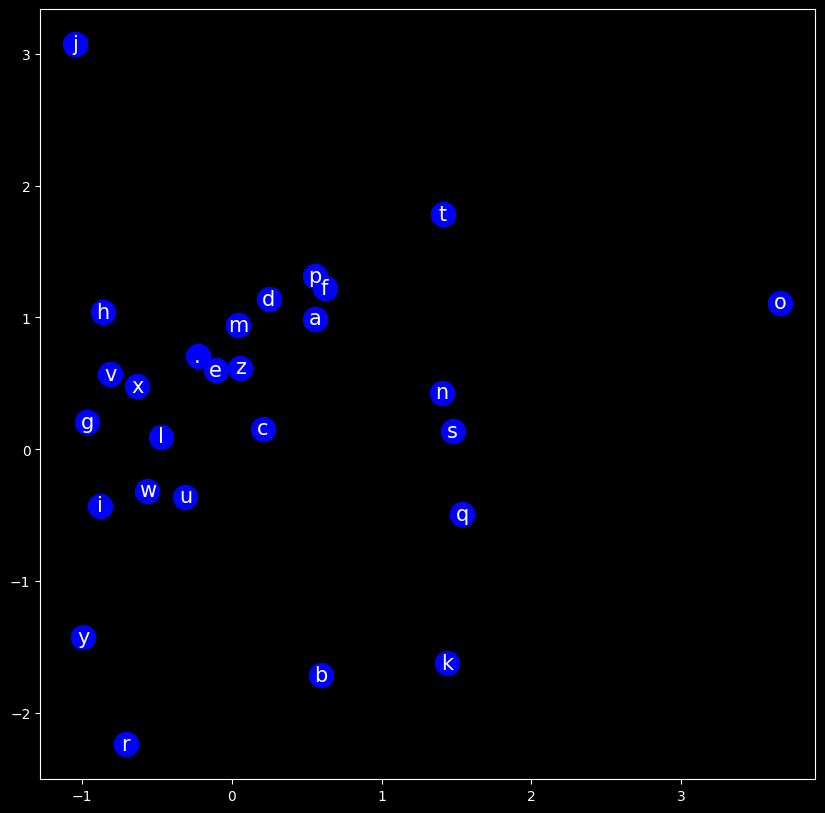

In [374]:
#build embedding matrix:
c = torch.randn((27 , 2))
emb = c[xtrain]
plot_embeddings(c)
plt.savefig('./data/ngram-embeddings1.png')
emb.shape , emb[0]

In [375]:
c[cti['.']]

tensor([-0.2298,  0.7044])

In [376]:
#initialize weights for first layer:
w1 = torch.randn((6, 100))
b = torch.randn(100)

#change embedding shape from (n , 3 , 2) -> (n , 6):

h = torch.tanh(emb.reshape((emb.shape[0] , -1)) @ w1 + b)
h.shape

torch.Size([182625, 100])

In [377]:
#compute outer layer:
w2 = torch.randn((100 , 27))
b2 = torch.randn(27)
logits = h @ w2 + b2
counts = logits.exp()
probs = counts / counts.sum(dim = 1 , keepdims= True)
torch.isnan(probs).sum()
loss = -probs[torch.arange(xtrain.shape[0]) , ytrain].log().mean()
loss

tensor(17.8472)

In [378]:
(counts.sum(dim = 1)).shape , (counts/ counts.sum(dim = 1 , keepdim = True)).shape

(torch.Size([182625]), torch.Size([182625, 27]))

# of parameters: 3481


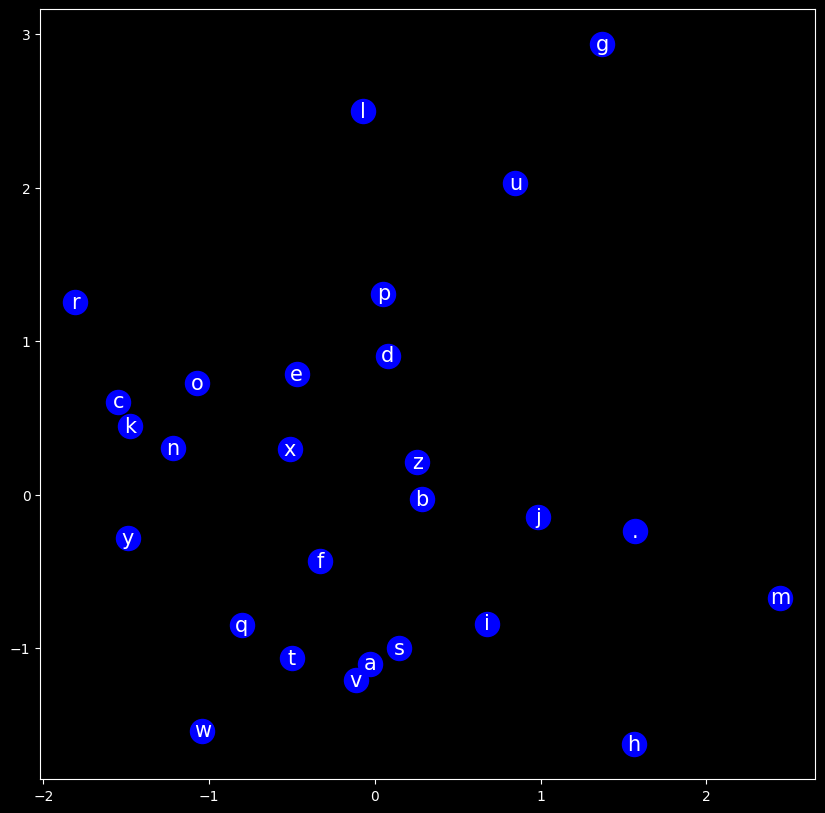

In [381]:
#final network:
gen = torch.Generator().manual_seed(2147483647)
c = torch.randn((27 , 2) , generator= gen)
w1 = torch.randn((6 , 100) , generator = gen)
b1 = torch.randn(100 , generator= gen)
w2 = torch.randn((100 , 27) , generator= gen)
b2 = torch.randn(27 , generator = gen)
parameters = [c , w1 , b1 , w2 , b2]
print(f"# of parameters: {sum(el.nelement() for el in parameters)}")
for p in parameters:
    p.requires_grad = True
plot_embeddings(c)
plt.savefig('./data/ngram-embeddings1.png')

In [382]:
xtrain.shape

torch.Size([182625, 3])

In [383]:
emb = c[xtrain]
h = torch.tanh(emb.reshape((xtrain.shape[0] , -1)) @ w1 + b1)
logits = h @ w2 + b2
# logits = logits - logits.max(dim = 1 , keepdim = True).values
print(torch.isnan(logits).sum())
counts = logits.exp()
print(torch.isnan(counts).sum())
probs = counts / counts.sum(dim = 1 , keepdims = True)
print(torch.isnan(probs).sum())
loss = -probs[torch.arange(xtrain.shape[0]) , ytrain].log().mean()
print(torch.isnan(loss).sum())
loss

tensor(0)
tensor(0)
tensor(0)
tensor(0)


tensor(19.5116, grad_fn=<NegBackward0>)

In [384]:
# x.shape , y.shape , counts.sum(dim = 1 , keepdim= True).shape , emb.shape , torch.arange(32).shape
torch.nn.functional.cross_entropy(logits , ytrain)

tensor(19.5116, grad_fn=<NllLossBackward0>)

In [385]:
#final network:
gen = torch.Generator().manual_seed(2147483647)
c = torch.randn((27 , 2) , generator= gen)
w1 = torch.randn((6 , 300) , generator = gen)
b1 = torch.randn(300 , generator= gen)
w2 = torch.randn((300 , 27) , generator= gen)
b2 = torch.randn(27 , generator = gen)
parameters = [c , w1 , b1 , w2 , b2]
print(f"# of parameters: {sum(el.nelement() for el in parameters)}")
for p in parameters:
    p.requires_grad = True

# of parameters: 10281


In [386]:
#test learning rates:
lre = torch.linspace(-3 , 0 , 1000)
lrs = 10**lre

In [387]:
lri = []
lossi = []
stepi = []
#mini-batch forward pass:
for i in range(40000):

    #get minibatch of size 32:

    ids = torch.randint(0 , xtrain.shape[0] , (64, ))
    # print(ids)

    ix = xtrain[ids]
    #simple forward pass:
    emb = c[ix].view((ix.shape[0] , -1))
    # print(emb.shape)
    # break
    h = torch.tanh(emb @w1 + b1)
    logits = h @ w2 + b2
    loss = torch.nn.functional.cross_entropy(logits , ytrain[ids])


    #backward pass:
    for p in parameters:
        p.grad = None
    loss.backward()


    lr = 0.1
    for p in parameters:
        p.data += -lr * p.grad

    #track stats

    lossi.append(loss.item())
    stepi.append(i)
    # lri.append(lr)

#final loss:
emb = c[xtrain]
h = torch.tanh(emb.view(-1 , 6) @ w1 + b1)
logits = h @ w2 + b2
loss = torch.nn.functional.cross_entropy(logits , ytrain)
loss.item()

2.416389226913452

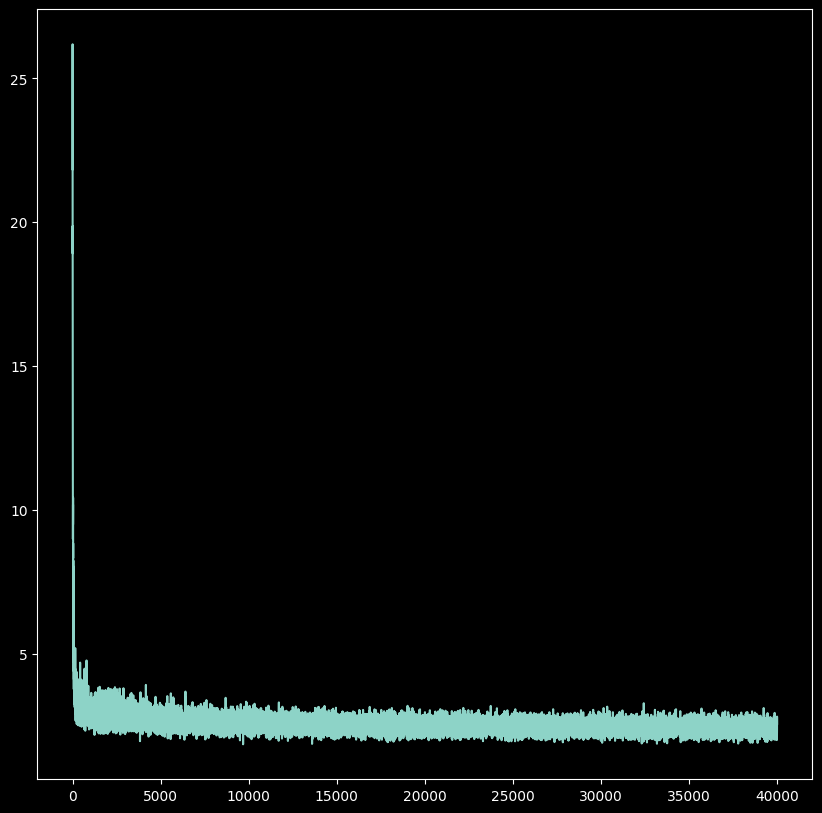

In [388]:
plt.figure(figsize = (10 , 10))
plt.plot(stepi , lossi)
plt.show()

In [389]:
#test loss on validation set:
emb = c[xval].view(xval.shape[0] , -1)
h = torch.tanh(emb @ w1 + b1)
logits = h @ w2 + b2
loss = torch.nn.functional.cross_entropy(logits , yval)
print(f"validation loss: {loss.item()}")

validation loss: 2.417811155319214


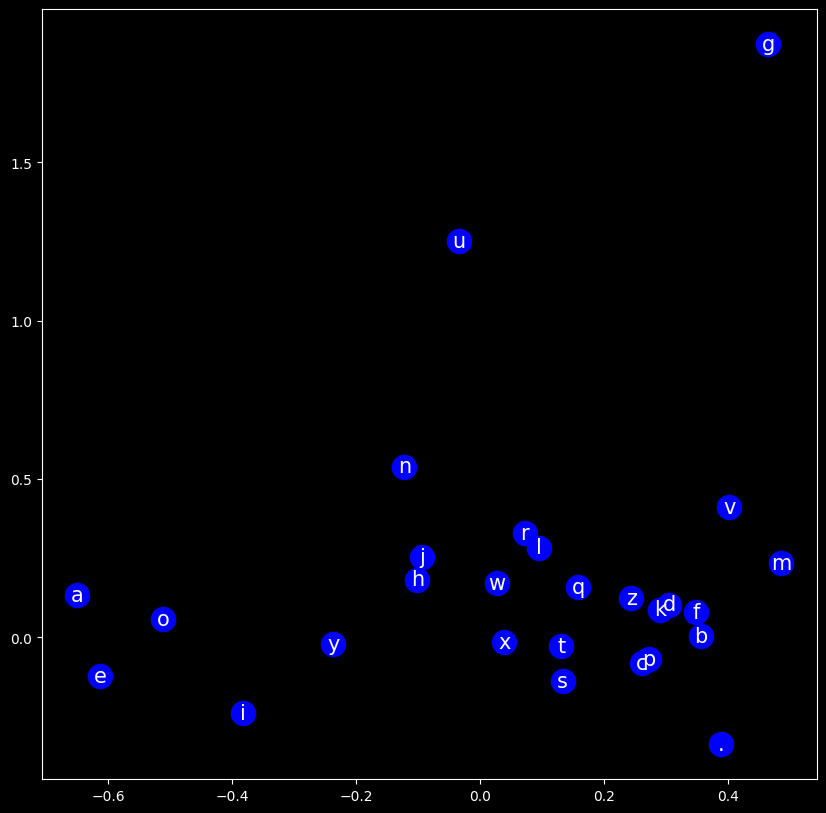

In [390]:
#visualize character embeddings:
plot_embeddings(c)
plt.savefig('./data/ngram-embeddings2.png')

2.389871120452881